<a href="https://colab.research.google.com/github/juanmed/epipolar_geometry/blob/main/Epipolar_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
!pip install opencv-contrib-python==4.4.0.44

In [260]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenA.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenB.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right01.jpg

--2021-05-19 12:02:49--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenA.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324949 (317K) [image/jpeg]
Saving to: ‘leuvenA.jpg.19’

leuvenA.jpg.19      100%[===================>] 317.33K  --.-KB/s    in 0.04s   

2021-05-19 12:02:49 (7.61 MB/s) - ‘leuvenA.jpg.19’ saved [324949/324949]

--2021-05-19 12:02:49--  https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenB.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312454 (305K) [imag

In [261]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

img1 = cv.imread("leuvenA.jpg",0)  #queryimage # left image
img2 = cv.imread("leuvenB.jpg",0) #trainimage # right image
print(img1.shape,img2.shape)

(563, 751) (563, 751)


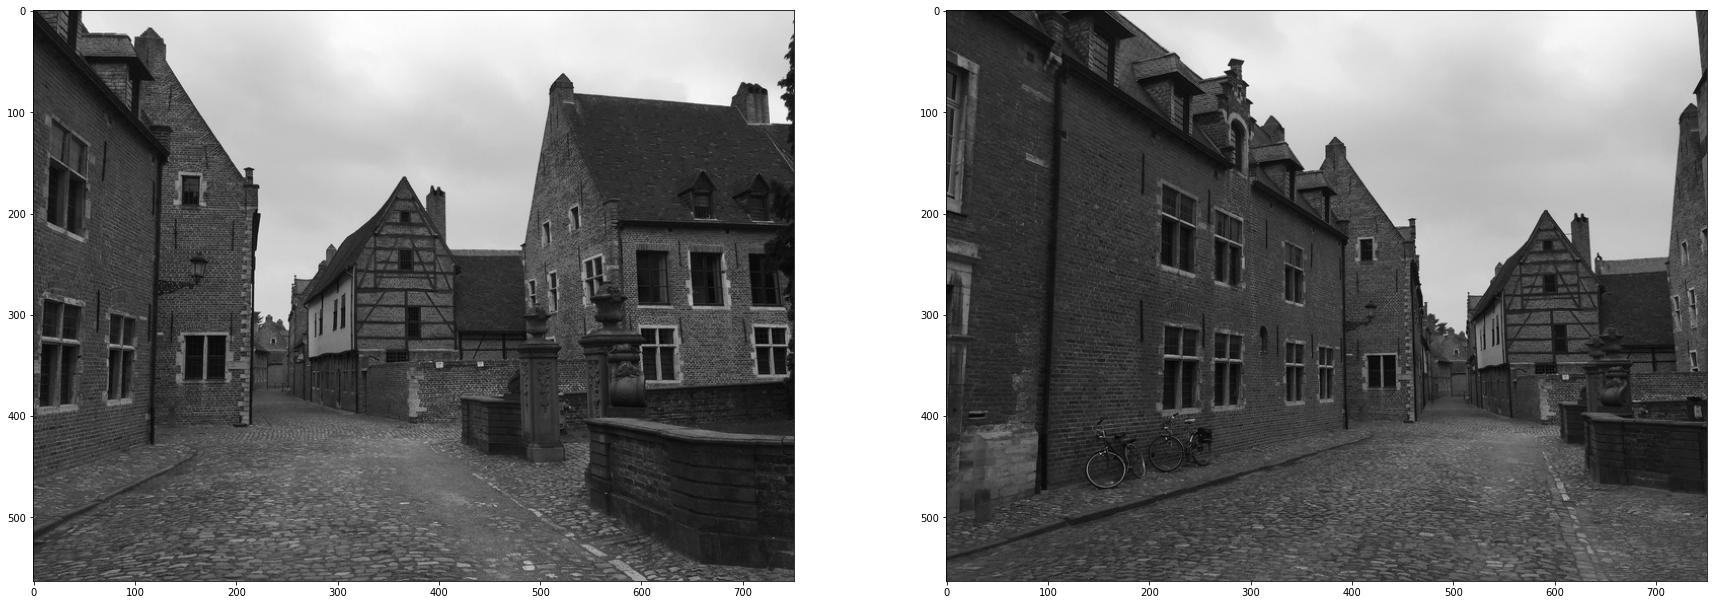

In [262]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

In [263]:
d = None
# from https://github.com/opencv/opencv/blob/master/samples/data/essential_mat_data.txt
# for leuven images
K = np.array([651.4462353114224, 0, 376.27522319223914, 0, 653.7348054191838, 280.1106539526218,0, 0, 1]).reshape(3,3)
# for left01, right01 images from https://github.com/opencv/opencv/blob/master/samples/data/left_intrinsics.yml
#K =  np.array([5.3591573396163199e+02, 0., 3.4228315473308373e+02, 0., 5.3591573396163199e+02, 2.3557082909788173e+02, 0., 0., 1.]).reshape(3,3)
#d = np.array([-2.6637260909660682e-01, -3.8588898922304653e-02, 1.7831947042852964e-03, -2.8122100441115472e-04, 2.3839153080878486e-01])

In [264]:
#img1u =  cv.undistort(	img1, K, d)
#img2u =  cv.undistort(	img2, K, d)
#fig = plt.figure(figsize=(30,30))
#ax1 = plt.subplot(1,2,1)
#ax2 = plt.subplot(1,2,2)
#ax1.imshow(img1u, cmap="gray")
#ax2.imshow(img2u, cmap="gray")

In [265]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [266]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]

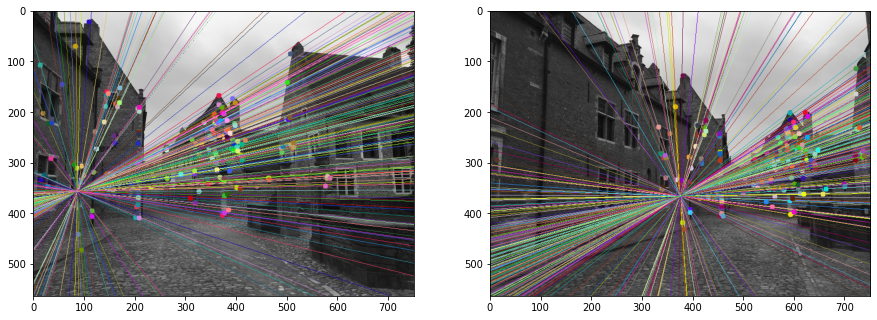

In [267]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img5)
ax2.imshow(img3)

In [268]:
E, mask =	cv.findEssentialMat(	pts1, pts2,K, cv.FM_LMEDS)
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]
_, R, t, mask =	cv.recoverPose(	E, pts1, pts2, K)


In [269]:
print("Rotation: ", R)
print("Translation:", t)
print(_)

Rotation:  [[ 0.91687925  0.04244604  0.39690147]
 [-0.04794229  0.99884237  0.00393142]
 [-0.39627513 -0.022633    0.9178528 ]]
Translation: [[0.0040507 ]
 [0.13352275]
 [0.99103747]]
232


In [270]:
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]

#Triangulation

In [275]:
T1 = np.hstack((np.identity(3),np.zeros((3,1))))
T2 = np.hstack((R,t))
homogeneous_points = cv.triangulatePoints(	T1, T2, pts1.T*1.0, pts2.T*1.0	)

In [276]:
homogeneous_points = homogeneous_points.T*1.0
for i in range(homogeneous_points.shape[0]):
  homogeneous_points[i] = homogeneous_points[i]/(homogeneous_points[i][3])
xdata = homogeneous_points[:,0]
ydata = homogeneous_points[:,1]
zdata = homogeneous_points[:,2]

In [278]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame({'x': xdata, 'y':ydata, 'z':zdata})
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

In [279]:
homogeneous_points

array([[2.34421271e+00, 3.81773829e+00, 3.75582392e-02, 1.00000000e+00],
       [2.20813527e+00, 5.29076506e+00, 1.61098070e-02, 1.00000000e+00],
       [2.27761754e+00, 4.35565709e+00, 2.23206722e-02, 1.00000000e+00],
       [2.22205167e+00, 5.05858517e+00, 1.60095188e-02, 1.00000000e+00],
       [2.28211100e+00, 4.19511283e+00, 1.98374040e-02, 1.00000000e+00],
       [2.28211100e+00, 4.19511283e+00, 1.98374040e-02, 1.00000000e+00],
       [2.20877088e+00, 5.22051940e+00, 1.40090612e-02, 1.00000000e+00],
       [2.25324399e+00, 4.55292330e+00, 1.62880878e-02, 1.00000000e+00],
       [2.29224478e+00, 4.01331663e+00, 1.93607763e-02, 1.00000000e+00],
       [2.29595000e+00, 3.96709403e+00, 1.98081272e-02, 1.00000000e+00],
       [2.36479366e+00, 2.94778214e+00, 2.30157966e-02, 1.00000000e+00],
       [2.29423239e+00, 3.79450829e+00, 1.36671686e-02, 1.00000000e+00],
       [2.29580289e+00, 3.76132747e+00, 1.34345562e-02, 1.00000000e+00],
       [2.29580289e+00, 3.76132747e+00, 1.34345562e